In [1]:
import pandas as pd
import numpy as np

from scipy.integrate import odeint

import lmfit

from tqdm import tqdm
tqdm.pandas()

from pathlib import Path
from utils import *
from plots import *

In [2]:
data_path = "data"

In [3]:
DataDownloader().download_all_csv()

In [4]:
covidpro_df = pd.read_csv(Path(data_path, CSVName.COVIDPRO_CSV))
dpc_regioni_df = pd.read_csv(Path(data_path, CSVName.DPC_REGIONI))
dpc_province_df = pd.read_csv(Path(data_path, CSVName.DPC_PROVINCE))
pop_prov_df = pd.read_csv(Path(data_path, CSVName.POP_PROV_CSV))

In [5]:
dpc_province_df['data'] = pd.to_datetime(dpc_province_df['data'])
dpc_regioni_df['data'] = pd.to_datetime(dpc_regioni_df['data'])
covidpro_df['Date'] = pd.to_datetime(covidpro_df['Date'])

In [6]:
dpc_province_df.denominazione_provincia = \
    dpc_province_df.denominazione_provincia.str \
        .replace("Forlì-Cesena", "Forli-Cesena")

dpc_regioni_df.denominazione_regione = \
    dpc_regioni_df.denominazione_regione.str \
        .replace("P.A. Trento", "Trentino Alto Adige") \
        .replace("P.A. Bolzano", "Trentino Alto Adige")

covidpro_df.Region = covidpro_df.Region.str \
                        .replace("P.A. Trento", "Trentino Alto Adige") \
                        .replace("P.A. Bolzano", "Trentino Alto Adige")

pop_prov_df.Territorio = pop_prov_df.Territorio.str \
                            .replace("Valle d'Aosta", "Aosta") \
                            .replace("Forlì-Cesena", "Forli-Cesena") \
                            .replace("Massa-Carrara", "Massa Carrara") \
                            .replace("L'Aquila", "L Aquila") \
                            .replace("Reggio nell'Emilia", 'Reggio nell Emilia')

In [7]:
def logistic_R0(t, R_0_start, k, x0, R_0_end):
    return (R_0_start-R_0_end) / (1 + np.exp(-k*(-t+x0))) + R_0_end

def logistic_R_0(t):
    return (R_0_start-R_0_end) / (1 + np.exp(-k*(-t+x0))) + R_0_end

def beta(t):
    return logistic_R_0(t) * gamma

def sird_calc(y, t, N, gamma, alpha, rho, beta):
    S, I, R, D = y
    dSdt = -beta(t) * S * I / N
    dIdt = -dSdt - (1 - alpha) * gamma * I - alpha * rho * I
    dRdt = (1 - alpha) * gamma * I
    dDdt = alpha * rho * I
    return dSdt, dIdt, dRdt, dDdt

def sird(province,
         R_0_start=2, # Inital R0
         k=0.2, # Decrease rate of R0
         x0=40, # Lockdown day
         R_0_end=0.3, # Final R0
         gamma=1/7, # How many days infection lasts
         alpha=0.01, # Death rate
         rho=1/9, # 1 over no. of days from infection until death
         days=101, # Total number of days to predict
         ):

    # Population
    N = pop_prov_df.loc[
        (pop_prov_df.Territorio == province) & 
        (pop_prov_df.Eta == "Total")
        ]['Value'].values[0]

    times = range(0, days)

    # S0, I0, R0, D0: initial conditions vector
    init = N-1, 1, 0, 0

    # Solve the model
    sirsol = odeint(sird_calc, init, times, args=(N, gamma, alpha, rho, beta))

    return sirsol.T

In [8]:
province = 'Firenze'

R_0_start = 2
k = 0.2
x0 = 40
R_0_end = 0.3
gamma = 1.0 / 7

sirsol = sird(province, gamma=gamma, R_0_start=R_0_start, R_0_end=R_0_end, x0=x0, k=k)
S, I, R, D = sirsol

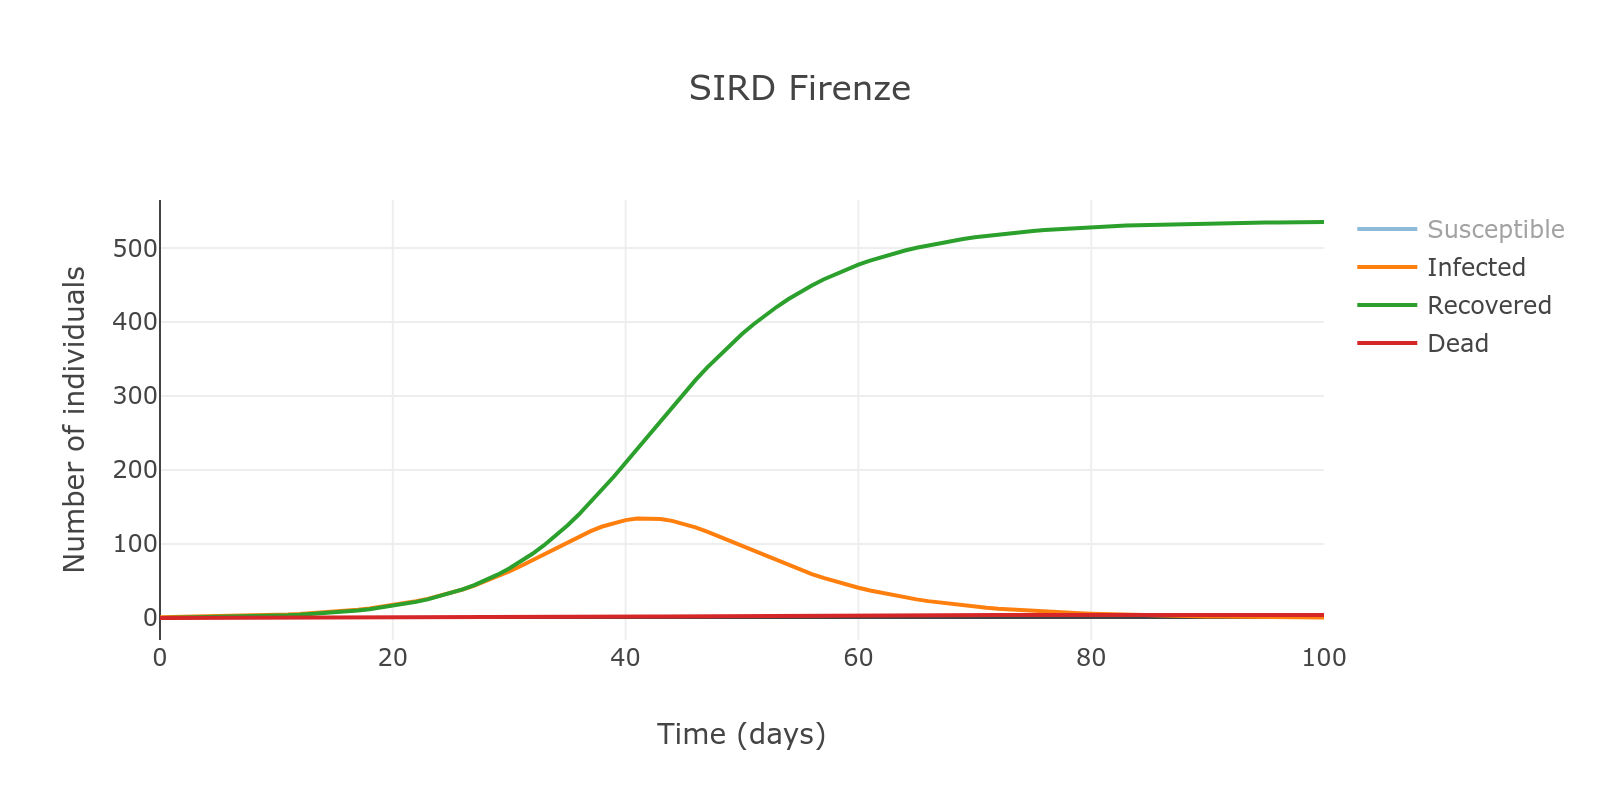

In [9]:
times = list(range(sirsol.shape[1]))

general_plot(t=times, 
             data=sirsol, 
             title=province,
             traces_visibility=['legendonly'] + [True]*3,
             output_image=True)

In [10]:
result = pd.DataFrame()
for prov in covidpro_df.Province.unique():
    S, I, R, D = sird(prov)
    tmp = pd.DataFrame(np.column_stack([[prov]*len(S),range(len(S)),S,I,R,D]))
    result = pd.concat([result, tmp])
    
result.columns = ["Province", "t", "S", "I", "R", "D"]
result.reset_index(drop=True,inplace=True)

In [ ]:
inter_dropdown_plot(options=result.Province.unique(), 
                    default_value='Firenze', 
                    dropdown_label='Province',
                    y=["S", "I", "R", "D"],
                    legend_titles=['Susceptible', 'Infected', 'Recovered', 'Dead'],
                    data=result,
                    group_column='Province',
                    x='t',
                    title='COVID-19 trendlines of ',
                    xtitle='Data',
                    ytitle='Unità',
                    output_image=False)

In [12]:
mapping = {
    'Curr_pos_cases': 2,
    'Tot_deaths': 4,
    'Deaths': ('Deaths', D),
    'Infected': ('New_cases', I)
}

In [13]:
def data_for_plot(compart, 
                  window=5, 
                  names=None, 
                  modes=None, 
                  query='20200603 > Date', 
                  df=covidpro_df):
                  
    if names is None:
        names = ['Real',
                'Real (rolling ' + str(window) + ' days)',
                'Predicted']
    
    if modes is None:
        modes = ['lines'] * 3

    title = compart + ' of ' + province
    
    c, l = mapping[compart]
    
    d1_real = df[df.Province == province].query(query)[c]
    d2_rolling = d1_real.rolling(window=window).mean().fillna(0)
    data = [d1_real.values, d2_rolling.values, l]

    return names, title, data, modes

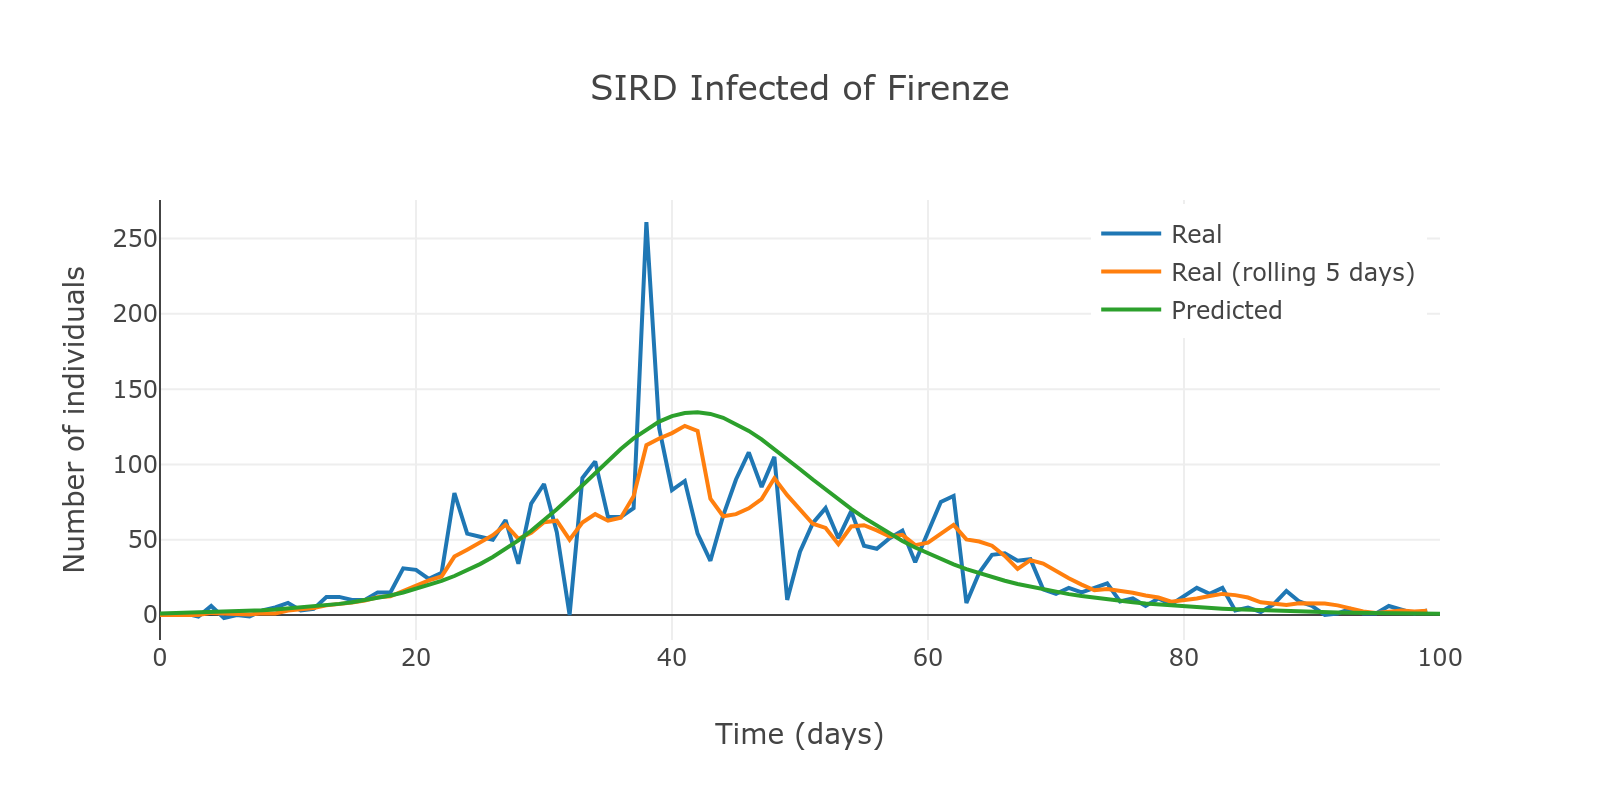

In [28]:
names, title, data, modes = data_for_plot('Infected')

general_plot(t=times,
             title=title,
             data=data,
             names=names,
             modes=modes,
             blend_legend=True,
             output_image=True)

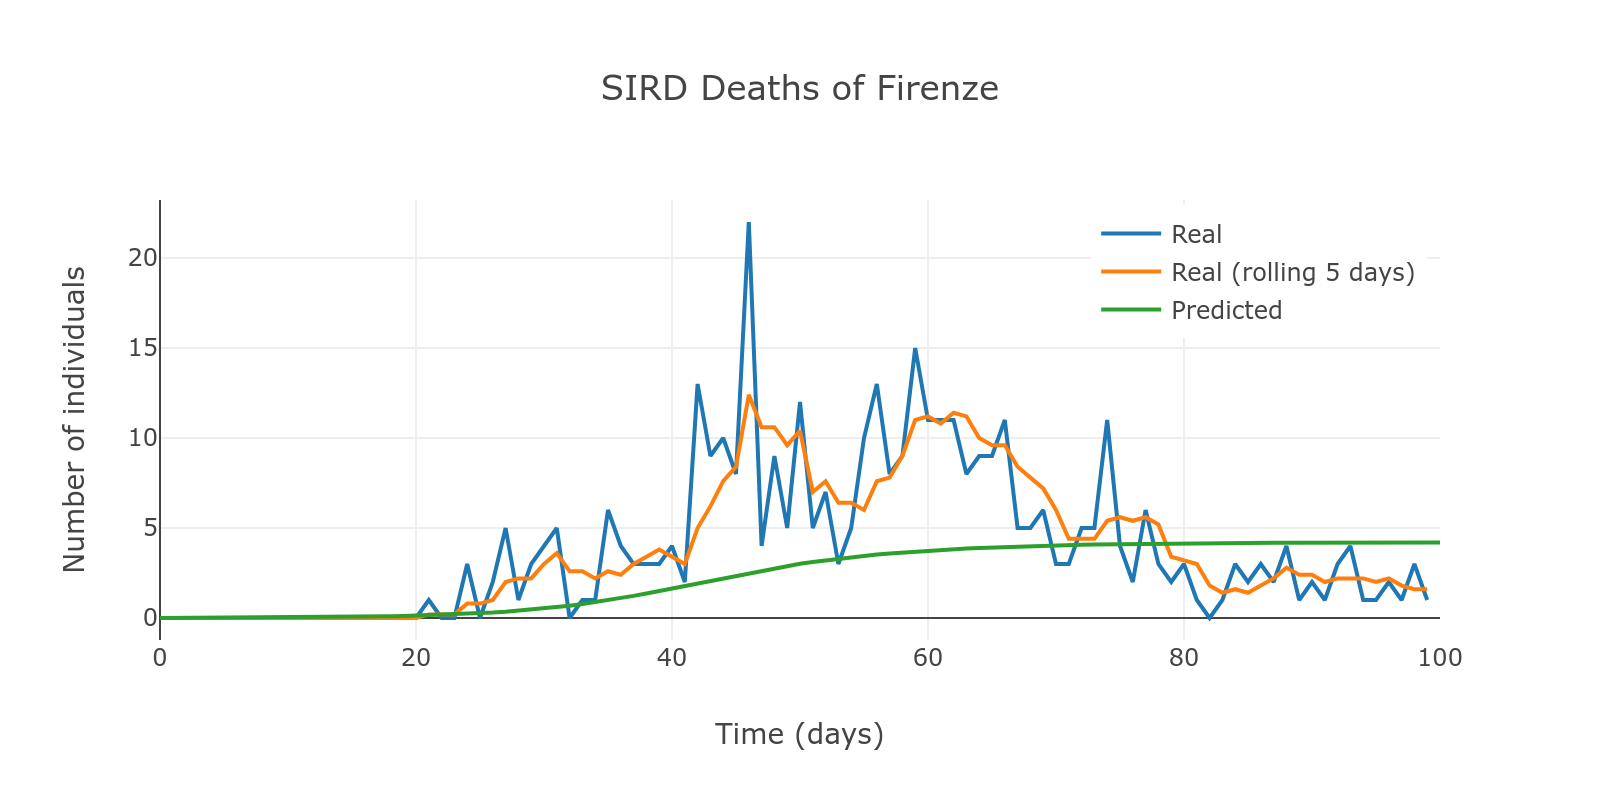

In [15]:
names, title, data, modes = data_for_plot('Deaths')

general_plot(t=times,
             title=title,
             data=data, 
             names=names,
             modes=modes,
             blend_legend=True,
             output_image=True)

In [16]:
def Model(days, N, R_0_start, k, x0, R_0_end):

    def beta(t):
        return logistic_R0(t, R_0_start, k, x0, R_0_end) * gamma

    y0 = N-1.0, 1.0, 0.0, 0.0,
    times = range(0, days)

    alpha = 0.05
    rho= 1/9

    sirsol = odeint(sird_calc, y0, times, args=(N, gamma, alpha, rho, beta))

    S, I, R, D = sirsol.T
    R0_over_time = [beta(i)/gamma for i in range(len(times))]

    return times, S, I, R, D, R0_over_time

In [17]:
province = 'Firenze'

compart = 'Curr_pos_cases'

data = covidpro_df[covidpro_df.Province == province].query('20200603 > Date')[compart]
N = pop_prov_df.loc[(pop_prov_df.Territorio == province) & (pop_prov_df.Eta == "Total")]['Value'].values[0]

outbreak_shift = 20

# {parameter: (initial guess, min value, max value)}
params_init_min_max = {
    "R_0_start": (3.0, 1.0, 6),
    "k": (0.3, 0.01, 5.0),
    "x0": (20, 0, 100),
    "R_0_end": (0.9, 0.1, 3.5)
    }

In [18]:
days = outbreak_shift + len(data)

if outbreak_shift >= 0:
    y_data = np.concatenate((np.zeros(outbreak_shift), data))
else:
    y_data = y_data[-outbreak_shift:]

# [0, 1, ..., days]
x_data = np.linspace(0, days-1, days, dtype=int)

def fitter(x, R_0_start, k, x0, R_0_end):
    ret = Model(days, N, R_0_start, k, x0, R_0_end)
    return ret[mapping[compart]][x] # 2 for I, 4 for D

In [19]:
mod = lmfit.Model(fitter)

for kwarg, (init, mini, maxi) in params_init_min_max.items():
    mod.set_param_hint(str(kwarg), value=init, min=mini, max=maxi, vary=True)

params = mod.make_params()

In [20]:
result = mod.fit(y_data, params, method="leastsq", x=x_data)

In [21]:
lmfit.report_fit(result)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 122
    # data points      = 120
    # variables        = 4
    chi-square         = 190498.384
    reduced chi-square = 1642.22745
    Akaike info crit   = 892.388870
    Bayesian info crit = 903.538837
[[Variables]]
    R_0_start:  1.96442235 +/- 0.00799240 (0.41%) (init = 3)
    k:          0.11107726 +/- 0.00370475 (3.34%) (init = 0.3)
    x0:         57.1922041 +/- 0.42139861 (0.74%) (init = 20)
    R_0_end:    1.02786142 +/- 0.00207262 (0.20%) (init = 0.9)
[[Correlations]] (unreported correlations are < 0.100)
    C(R_0_start, x0)      = -0.981
    C(R_0_start, k)       = -0.936
    C(k, x0)              =  0.861
    C(k, R_0_end)         =  0.810
    C(R_0_start, R_0_end) = -0.631
    C(x0, R_0_end)        =  0.470


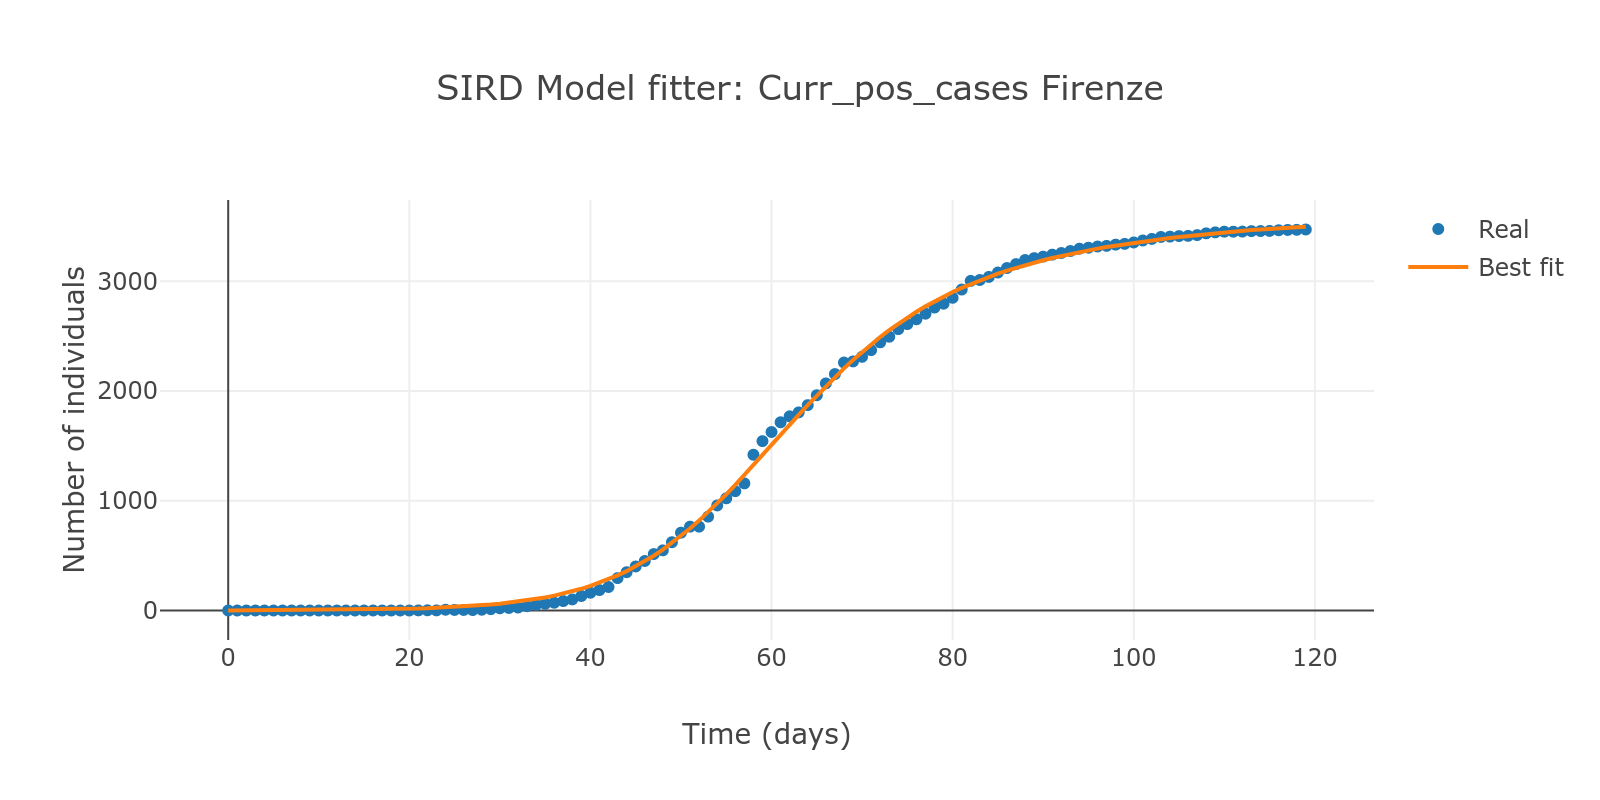

In [22]:
general_plot(t=x_data,
             title='Model fitter: ' + compart + ' ' + province,
             data=[result.data, result.best_fit], 
             names=['Real', 'Best fit'],
             modes=['markers', 'lines'],
             blend_legend=False,
             output_image=True)

In [23]:
result.best_values

{'R_0_start': 1.9644223517994095,
 'k': 0.1110772564470416,
 'x0': 57.192204076935504,
 'R_0_end': 1.0278614225286997}

In [24]:
R_0_start, k, x0, R_0_end = result.best_values.values()